In [1]:
descargar_data_apartment_ = False
# when False: descarga data que contiene todas las columnas adicionales y todas las property_type
# change to True: para descargar data_apartment_i recuperados en la seccion de "Cierre". 

# WORKSHOP 2

------------

**<u>GRUPO 4<u>**

Digital House

link git hub: https://github.com/grupo4dhds/grupo4_git.git

--------------

## CONTENIDO

### <u>Seteo de la notebook<u>
**item celda 1:**

     - MODULO DE IMPORTACION DE LIBRERIAS
**item celda 2:**

    - CARGA DEL DATASET Y ANULACION DE LOS WARNING
    
**item celda 3:**

    - MODULO DE FUNCIONES
    
### <u>Limpieza del dataset<u>
**items celda 4:**
	
	- 1. COLUMNAS REDUNDANTES
		- GUARDADO: data_cruda
        - 1.1 Recupero place_name
		- 1.2 Filtrado columnas de trabajo


	- 2. ANALISIS DE COTIZACION
		- 2.1 Creacion de columna soporte previsoria
		- 2.2 Filtrado de datos ilogicos
		- 2.3 Creacion de variable soporte - tipo de cambio
		- 2.4 Unificacion del tipo de cambio en el precio
		- 2.5 Filtrado y Recupero de price_usd_per_m2

	- 3. REACIONDICIONAMIENTO DEL DATASET
		- 3.1 Filtrado de columnas
		- 3.2 Obtencion de muestra: currency_nan
		- 3.3 Obtencio de muestra: surface_nan
		- GUARDADO: limpieza_1

**items celda 5:**

	- 4. LIMPIEZA POR COUNT Y CV
		- 4.1 Filtrado por cantidad de publicaciones máximas en state_name
		- 4.2 Filtrado por cantidad de publicaciones mínimas en place_name
		- GUARDADO: limpieza_2
		- 4.3 Filtrado por coeficiente de variación - price_usd_per_m2 - CV < 0.99 (1)
		- GUARDADO: limpieza_3
		- 4.4 Filtrado por coeficiente de variación - surface_total_in_m2 - CV < 0.99  (2)
		- GUARDADO: limpieza_4

**items celda 6:**

	- 5. FILTRADO DE OUTLIERS POR SUPERFICIE TOTAL 
		- GUARDADO: limpieza_5_aux
		- GUARDADO: limpieza_5

	- 6. RECUPERO DE LA DATA SUPERFICIE TOTAL
		- GUARDADO: recupero_5
	
**items celda 7:**

	- 7. FILTRADO DE OUTLIERS POR PRECIO USD POR M2 
		- GUARDADO: limpieza_6_aux
		- GUARDADO: limpieza_6
        
### <u>Reacondicionamiento del dataset<u>
**item celda 8:**
    
    - REINCORPORACION DE STORE DESDE UN CHECKPOINT ANTERIOR
**item celda 9:**

    - RECORTE OUTLIERS PRICE
    
**item celda 10:**
    
    - GUARDADO: data
    
**item celda 11:**

    - NORMALIZACION: ESTADO UNITARIO (NO SIRVE)
**item celda 12:**

    - NORMALIZACION: ESTANDARIZACION (NO SIRVE)
    
### <u>Visualizacion<u>
**item celda 13:**

    - PORCENTAJES DE NANS
**item celda 14:**

    - DISTRIBUCIONES DE PROPERTY_TYPE EN FUNCION DE STATE_NAME
**item celda 15:**

    - DISPERSION DE SUPERFICIE_TOTAL Y PRICE POR PROPERTY_TYPE
**item celda 16:**
    
    - DISPERSION DE PRICE Y PRICE_USD_PER_M2 POR PROPERTY_TYPE
**item celda 17:**

    - RANGO DE VALORES Y UBICACIONES
**item celda 18:**

    - HISTOGRAMAS ESTANDARIZADOS

### <u>Cierre<u>
**itema celda :**
    
    - limpieza outlier por superficie y por state_name
    - limpieza visual de price por state_name
    - categorizacion place_name en apartment por count valor "otros"
    - recupero columnas descriptivas
        - recupero de columnas categoricas de data_cruda: creacion data_apartment_1
        - recupero de columnas categoricas de data_geo: creacion data_apartment_2
        - union de datasets: creacion data_apartment_3
    - categorizacion de la superficie por la media de superficie total segun place_name
        - creacion data_apartment_4
        - creacion data_apartment_5
    - descargar la base de datos
    
-------------------
<u>mail<u>
        
grupo4dhds@gmail.com / a123b456c789
    
<u>cta github<u>
        
grupo4dhds / a123b456c789!_!

-----------------
### <u>Seteo de la notebook<u>

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
data = pd.read_csv('properatti.csv')
Dicto = {}

warnings.filterwarnings('ignore')

In [4]:
def data_info(data, name='data'):
    df = pd.DataFrame(pd.Series(data.columns))
    df.columns = ['columna']
    df.columns.name = f'df de {name}'
    df.index.name = 'index'
    df['Nan'] = data.isna().sum().values
    df['dtype']  = data.dtypes.values
    df['count'] = data.count().values
    df['pct_nan'] = round(df['Nan']/data.shape[0]*100,2)
    df['count_unique'] = [len(data[elemento].value_counts()) for elemento in data.columns]
    return df

def explore_count(frame, label_1):
    df = pd.DataFrame(index = pd.Series(frame[label_1].unique()))
    frame['all_one'] = 1
    #cantidad de datos publicados
    df = df.join(frame.groupby(label_1)['all_one'].count())
    df.columns = ['total']
    frame.drop('all_one', axis=1, inplace=True)
    return df

def explore_count_by(frame,label_1, label_2, df):
    # cantidad de tipo apartment
    set_check = list(set(frame[label_2]))
    frame['all_one'] = 1
    for i,propiedad in enumerate(set_check):
        serie_check =frame[frame[label_2]==propiedad].groupby(label_1)['all_one'].count()
        df['count_'+propiedad] = 0 + serie_check
    frame.drop('all_one', axis=1, inplace=True)
    return df

def explore_statics_count(frame, label_1, label_2, label_3, df):
    # precio promedio y la mediana de precio para state_name, property_type
    data_check = frame.groupby([label_1, label_2])[label_3].aggregate(['mean', 'std', 'median'])
    data_check.reset_index(inplace=True)
    data_check = data_check.pivot_table(index=label_1, columns=label_2)
    set_check = list(set(data[label_2]))
    for propiedad in set_check:
        df[propiedad+'_mean_'+label_3] = 0 + data_check.loc[:]['mean'][propiedad]
        df[propiedad+'_std_'+label_3] = 0 + data_check.loc[:]['std'][propiedad]
        df[propiedad+'_median_'+label_3] = 0 + data_check.loc[:]['median'][propiedad]
    # dispersion de los precios
    for propiedad in set_check:
        df['CV_'+propiedad+'_'+label_3] = df[propiedad+'_std_'+label_3]/df[propiedad+'_mean_'+label_3]
    return df

def rango_extremos(frame, label, quant_list):
        for i,v in enumerate(quant_list):
            quant_list[i] = v /100
        
        rango_outlier = frame[label].quantile(quant_list)
        rango_outlier = list(rango_outlier)
        impresion = [round(elemento,1) for elemento in rango_outlier]
        print ('range_outlier: type: {}, len: {}, value: {}'.format(type(rango_outlier),len(rango_outlier), impresion))
        return rango_outlier
    
def mascara_outlier_index_list(frame, label, rango_outlier): # el problema que tengo es sacarme solo True de encima y quedarme con el indice de los False - 
    mascara_outlier = (frame[label].dropna() >= rango_outlier[0]) & (frame[label].dropna() <= rango_outlier[1])  #ME QUEDO CON EL RANGO FALSE
    #resulta: mascara booleana quiero quedarme con el indice de los False
    lista_elementos = mascara_outlier.values
    lista_indices = mascara_outlier.index
    lista_elementos = list(lista_elementos)
    lista_indices = list(lista_indices)
    lista_result = []
    for i, booleano in enumerate(lista_elementos):
        if booleano == False:
            lista_result.append(lista_indices[i])
    return lista_result

def check_range(frame, label, rango):
    mask_data = (frame[label] <= rango[0]) | (frame[label] >= rango[1])  # tomo True los valores que caen fuera del rango
    # necesito solo los indices que sean True
    lista_elementos = list(mask_data.values)
    lista_indices = list(mask_data.index)
    lista_result = []
    for i, booleano in enumerate(lista_elementos):
        if booleano == True:
            lista_result.append(lista_indices[i])
    return lista_result

def cambia_nombre_columnas(data=data, **kwarg):
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
    for key in kwarg.keys():
        data.rename(kwarg[key], axis=1, inplace=True)
    return data

def cambia_orden_columnas(check_list, data=data, safe=1): # safe: es para conservar la primera columna con indice[0]
    label_list = list(data.columns)
    for i in range(len(check_list)):
        label_list.remove(check_list[i])
        label_list.insert(i+safe, check_list[i])
        data = data.reindex(label_list, axis=1)
    return data

def estandarizar(frame, label):
    serie_check = frame[label]
    mean = serie_check.mean()
    std = serie_check.std(ddof=0)
    return [(x - mean) / std for x in serie_check]

--------------------
### <u>Limpieza dataset<u>

In [5]:
# 1. COLUMNAS REDUNDANTES
# # GUARADADO DE LA DATA # #
df = data_info(data, 'data_cruda')
Dicto['data_cruda'] = df.to_dict(), data.to_dict()

# 1.1 Recupero datos colgados
data.loc[data.place_name.isna(),'place_name'] = 'Tigre'
# 1.2 COLUMNAS DE TRABAJO
columnas = ['property_type', 'place_name', 'state_name', 'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2']
data = data.filter(columnas, axis=1)


# 2. ANALISIS DE COTIZACION
# 2.1: creacion de una columna soporte de superficie
mask_data = data.surface_total_in_m2.notna() & data.surface_covered_in_m2.notna()
mask_data = data[mask_data].surface_total_in_m2 >= data[mask_data].surface_covered_in_m2 # comprobamos que haya logica Total > Cubierto
data['surface_total_in_m2'].fillna(0, inplace=True)
data['surface_covered_in_m2'].fillna(0, inplace=True)
data['surface_total_in_m2_mod'] = np.maximum(data.surface_total_in_m2, data.surface_covered_in_m2)
data['surface_total_in_m2_mod'] = data['surface_total_in_m2_mod'].replace(0,np.nan)
data['surface_total_in_m2'] = data['surface_total_in_m2'].replace(0,np.nan)
data['surface_covered_in_m2'] = data['surface_covered_in_m2'].replace(0,np.nan)

# 2.2 #comprobamos que hay valores ilogicos porque price_usd_per_m2 es mayor a price_per_m2 que esta en pesos
mask_data = data.currency == 'ARS'
data.drop((data[mask_data].loc[data.price_per_m2 < data.price_usd_per_m2]).index, inplace=True)

# 2.3: DEFINICION DEL TIPO DE CAMBIO
tc = np.mean(data.price_aprox_local_currency/data.price_aprox_usd) # tc promedio 17.6444

# 2.4: PASAR LA COLUMNA price A UN SOLO TIPO DE CAMBIO
mask_data = data.currency == 'ARS'
data.loc[mask_data, 'price'] = data[mask_data].price / tc
data.loc[mask_data, 'currency'] = 'USD'
mask_data = data.loc[:,'currency'] != 'USD'
mask_data = data.loc[mask_data,'currency'].dropna().index
data.drop(mask_data, inplace=True)

# 2.5: ELIMINAMOS 870 VALORES INCOHERENTES Y RECUPERO DE PRICE_USD_PER_M2
data['price_usd_per_m2_recovery'] = data['price'] / data['surface_total_in_m2_mod']
data['diff_pct_change'] = (data['price_usd_per_m2_recovery'] / data['price_usd_per_m2'] -1 )*100
# ' Elimino del dataset de trabajo los que tenian desvios de +- 4.75%'
mask_data = data.loc[(data['diff_pct_change'] < -4.75) | (data['diff_pct_change'] > 4.75)].index
data.drop(mask_data, inplace=True)
data['price_usd_per_m2'].fillna(data['price_usd_per_m2_recovery'], inplace=True)

# 3 REACONDICIONAMIENTO DEL DATASET
# 3.1: FILTRADO DE COLUMNAS
columnas = ['diff_pct_change','price_usd_per_m2_recovery', 'surface_total_in_m2_mod', 'price_aprox_usd', 'price_per_m2', 'price_aprox_local_currency']
data.drop(columnas, axis=1, inplace=True)
    
# 3.2: TOMAMOS MUESTRA DE LOS CURRENCY NANS
df = data_info(data[data.currency.isna()], 'currency_nan')
Dicto['currency_nan'] = df.to_dict(), data[data.currency.isna()].to_dict()

# 3.3: TOMAMOS MUESTRA DE SURFACE_COVERED ISNA() Y SURFACE_TOTAL ISNA()
mask_1 = data.surface_total_in_m2.isna()
mask_2 = data.surface_covered_in_m2.isna()
df = data_info(data[mask_1 & mask_2], 'surface_nan')
Dicto['surface_nan'] = df.to_dict(), data[mask_1 & mask_2].to_dict()

# # GUARDADO DE LA DATA # #
data = data.drop(data[mask_1 & mask_2].index)
data = data.drop(data[data.currency.isna()].index)

df = data_info(data, 'limpieza_1')
Dicto['limpieza_1'] = df.to_dict(), data.to_dict()

In [6]:
# 4. LIMPIEZA POR COUNTS Y CV
# 4.1 LIMPIEZA POR STATE_NAME EN FUNCION DEL COUNT: NOS QUEDAMOS CON LAS 7 PROVINCIAS/LOCALIDADES CON MAYOR CANTIDAD DE PUBLICACIONES
df = explore_count(data, 'state_name');
df.sort_values(by='total', ascending=False, inplace=True)
lista_state = list(df.index)[:8]
lista = []
for elemento in lista_state:
    lista.append(list(data[data.state_name == elemento].index))
lista_mascara = []
for elemento in lista:
    lista_mascara += elemento

data = data.filter(lista_mascara, axis=0)

# 4.2 LIMPIEZA POR PLACE_NAME EN FUNCION DEL COUNT: NOS QUEDAMOS CON LAS CIUDADES/BARRIOS QUE TENGAN MAS DE 45 PUBLICACIONES \ check:<#df.total.value_counts().to_frame().reset_index().sort_values(by = 'index', ascending=True).head(50)>
lista_filter = []
for ix, state in enumerate(lista_state):
    mascara_iteracion = data.state_name == state
    df = explore_count(data[data.state_name == state], 'place_name');
    mask = df.total > 45
    lista_city = list(df[mask].index)

    lista = []
    for elemento in lista_city:
        lista.append(list(data[mascara_iteracion].loc[data.place_name == elemento].index))

    lista_mascara = []
    for elemento in lista:
        lista_mascara += elemento
    
    lista_filter += lista_mascara
        
data = data.filter(lista_filter, axis=0)

# # GUARDADO DE LA DATA # #
df = data_info(data, 'limpieza_2')
Dicto['limpieza_2'] = df.to_dict(), data.to_dict()

# 4.3 LIMPIEZA POR COEFICIENTE DE VARIACION: NOS QUEDAMOS CON LOS PROPERTY_TYPE(EN FUNCION DE PLACE_NAME) QUE TENGAN MENOS DE 0.99 DE CV EN PRICE_USD_PER_M2
# # CREACION DE DATAFRAME ESTADISTICO # #
df = explore_count(data, 'place_name')
df = explore_count_by(data, 'place_name', 'property_type', df)
df = explore_statics_count(data,'place_name', 'property_type','price_usd_per_m2',df)

#  # FILTROS # #
#nomenclatura: el primer numero hace reperenfencia al tipo de propiedad, y el segundo hace referencia a la cantidad de filtros que lleva implementandose
filtro_1_1 = list(df.columns)[:2]
filtro_2_1 = list(df.columns)[:3:2]
filtro_3_1 = list(df.columns)[:4:3]
filtro_4_1 = list(df.columns)[:5:4]

filtro_1_2 = list(df.columns)[5:8]
filtro_2_2 = list(df.columns)[8:11]
filtro_3_2 = list(df.columns)[11:14]
filtro_4_2 = list(df.columns)[14:17]

filtro_1_3 = list(df.columns)[17:18]
filtro_2_3 = list(df.columns)[18:19]
filtro_3_3 = list(df.columns)[19:20]
filtro_4_3 = list(df.columns)[20:21]

filtro_1 = filtro_1_1 + filtro_1_2 + filtro_1_3
filtro_2 = filtro_2_1 + filtro_2_2 + filtro_2_3
filtro_3 = filtro_3_1 + filtro_3_2 + filtro_3_3
filtro_4 = filtro_4_1 + filtro_4_2 + filtro_4_3

lista_filtros = [filtro_1, filtro_2, filtro_3, filtro_4]

# # CATEGORIZACION # #
# Se crea la columna low_coeficiente_variacion = std/mean
diccionario_prop_type_low_cv = {}

for filtro in lista_filtros: 
    label = str(list(df.loc[:,filtro].columns)[1])
    label = label.replace('count_', '')
    df['LowCV_' + label] = df.loc[:,filtro].eval(str(list(df.loc[:,filtro].columns)[-1])+' < 0.99') #creacion de columna categorica
    mask = df['LowCV_' + label] == True
    diccionario_prop_type_low_cv[label] = list(df.loc[mask,filtro].index)
    
# # FILTRADO # #
# En base a la categoria obtenida se aplica el método de filtrado
set_check = set(list(data.property_type))
lista_dict = list(diccionario_prop_type_low_cv.keys())
lista_filter = []
lista_mascara = []

for ix, propiedad in enumerate(set_check):
    if propiedad == lista_dict[ix]:
        lista_city = diccionario_prop_type_low_cv[propiedad]
        lista = []
        mascara = data.property_type == propiedad
        
        for elemento in lista_city:
            lista.append(list(data.loc[mascara].loc[data.place_name==elemento].index)) # estamos hablando que el tipo de propiedad en la localidad especifica tiene bajos CV, y me quedo con los index

        lista_mascara += lista
for elemento in lista_mascara:
    lista_filter += elemento

data = data.filter(lista_filter, axis=0)

# # GUARDADO DE LA DATA # # 
df = data_info(data, 'limpieza_3')
Dicto['limpieza_3'] = df.to_dict(), data.to_dict()

# 4.4 LIMPIEZA POR COEFICIENTE DE VARIACION: NOS QUEDAMOS CON LOS PROPERTY_TYPE(EN FUNCION DE PLACE_NAME) QUE TENGAN MENOS DE 0.99 DE CV EN SURFACE_TOTAL_IN_M2
# # CREACION DE DATAFRAME ESTADISTICO # #
df = explore_count(data, 'place_name')
df = explore_count_by(data, 'place_name', 'property_type', df)
df = explore_statics_count(data,'place_name', 'property_type','surface_total_in_m2',df)

#  # FILTROS # #
#nomenclatura: el primer numero hace reperenfencia al tipo de propiedad, y el segundo hace referencia a la cantidad de filtros que lleva implementandose
filtro_1_1 = list(df.columns)[:2]
filtro_2_1 = list(df.columns)[:3:2]
filtro_3_1 = list(df.columns)[:4:3]
filtro_4_1 = list(df.columns)[:5:4]


filtro_1_2 = list(df.columns)[5:8]
filtro_2_2 = list(df.columns)[8:11]
filtro_3_2 = list(df.columns)[11:14]
filtro_4_2 = list(df.columns)[14:17]


filtro_1_3 = list(df.columns)[17:18]
filtro_2_3 = list(df.columns)[18:19]
filtro_3_3 = list(df.columns)[19:20]
filtro_4_3 = list(df.columns)[20:21]


filtro_1 = filtro_1_1 + filtro_1_2 + filtro_1_3
filtro_2 = filtro_2_1 + filtro_2_2 + filtro_2_3
filtro_3 = filtro_3_1 + filtro_3_2 + filtro_3_3
filtro_4 = filtro_4_1 + filtro_4_2 + filtro_4_3

lista_filtros = [filtro_1, filtro_2, filtro_3, filtro_4]

# # CATEGORIZACION # #
# Se crea la columna low_coeficiente_variacion = std/mean
diccionario_prop_type_low_cv = {}

for filtro in lista_filtros: 
    label = str(list(df.loc[:,filtro].columns)[1])
    label = label.replace('count_', '')
    df['LowCV_' + label] = df.loc[:,filtro].eval(str(list(df.loc[:,filtro].columns)[-1])+' < 0.99') #creacion de columna categorica
    mask = df['LowCV_' + label] == True
    #Dicto
    diccionario_prop_type_low_cv[label] = list(df.loc[mask,filtro].index)
    
# # FILTRADO # #
# En base a la categoria obtenida se aplica el método de filtrado
set_check = set(list(data.property_type))
lista_dict = list(diccionario_prop_type_low_cv.keys())
lista_filter = []
lista_mascara = []

for ix, propiedad in enumerate(set_check):
    if propiedad == lista_dict[ix]:
        lista_city = diccionario_prop_type_low_cv[propiedad]
        lista = []
        mascara = data.property_type == propiedad
        
        for elemento in lista_city:
            lista.append(list(data.loc[mascara].loc[data.place_name==elemento].index)) 

        lista_mascara += lista
for elemento in lista_mascara:
    lista_filter += elemento

data = data.filter(lista_filter, axis=0)

# # GUARDADO DE LA DATA # # 
df = data_info(data, 'limpieza_4')
Dicto['limpieza_4'] = df.to_dict(), data.to_dict()

In [7]:
# 5. ELIMINACION DE OUTLIERS POR SURFACE_COVERED_IN_M2
print ('EXCLUSION DE OUTLIERS EN SUPERFICIE')

data_aux = pd.DataFrame(Dicto['limpieza_3'][1]) # porque con las dos limpiezas de CV resultan 23 stores solamente
lista = [data_aux, data]

lista_rangos_main = []
lista_drops_main = []

for ix, data_sup in enumerate(lista):
    
    serie_check = data_sup.property_type
    set_check = set(list(serie_check))
    lista_rangos = []
    lista_drops = []
    if ix == 0: print ('='*20,'\nvalores data_aux\n', '='*20)
    if ix == 1: print ('='*20,'\nvalores data\n', '='*20)
        
    for elemento in set_check:
        print ('-----------------Iteracion en {}-----------------'.format(elemento))
        mascara_iter_1 = serie_check == elemento
        
        if ix == 1: #data
            if elemento == 'house':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_total_in_m2', [0.5, 90])
            if elemento == 'apartment':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_total_in_m2', [0.5, 97.5])
            if elemento == 'store':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_total_in_m2', [0.5, 97.5])
            if elemento == 'PH':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_total_in_m2', [0.5, 97.5])
                
        if ix==0:# data_aux
            if elemento == 'store' or elemento == 'house':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_covered_in_m2', [10, 90])
            else:
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_covered_in_m2', [2.5, 97.5])
    
        lista_rangos.append(rango_outlier)
        
        # IMPUTACION COLUMNA        

        serie_outlier = data_sup.surface_total_in_m2.loc[mascara_iter_1]
        mask_data = data_sup.loc[serie_outlier.index, 'surface_total_in_m2'].dropna()
        indice_outlier = mascara_outlier_index_list(data_sup.loc[mask_data.index], 'surface_total_in_m2', rango_outlier)    
    
        
        lista_drops.append(indice_outlier)

    lista_rangos_main.append(lista_rangos)   
    lista_drops_main.append(lista_drops)
    for lista_indices in lista_drops:
        data_sup.drop(lista_indices, inplace=True)

    print ('--------------------------------------------------------------------------------\n')   
    lista[ix] = data_sup

# # GUARDADO DE LA DATA # #    
df = data_info(lista[0], 'limpieza_5_aux')
Dicto['limpieza_5_aux'] = df.to_dict(), lista[0].to_dict()

df = data_info(lista[1], 'without_outliers_surface')
data = lista[1]
Dicto['limpieza_5'] = df.to_dict(), lista[1].to_dict()    
    
# 6. RECUPERACION DE DATOS SURFACE_COVERED:

print ('\nRECUPERO DATA: surface_covered_in_m2\n')

for ix, data_sup in enumerate(lista):
    data_sup['surface_recovery'] = data_sup['price'] / data_sup['price_usd_per_m2']
    serie_check = data_sup['surface_recovery']
    serie_check.dropna(inplace=True)
    mask_data = data_sup.surface_total_in_m2.isna()
    for i, propiedad in enumerate(set_check):
        mascara_iter_1 = serie_check == propiedad
        data_check = data_sup.loc[mask_data].loc[mascara_iter_1]
        lista_drop = check_range(data_check, 'surface_recovery', lista_rangos_main[ix][i])
        data_sup.drop(lista_drop, inplace=True)
    # RECUPERO DE LA DATA    
    data_sup.surface_covered_in_m2.fillna(data_sup.surface_recovery, inplace=True)
    data_sup.drop('surface_recovery', axis=1, inplace=True)
    lista[ix] = data_sup

# # GUARDADO DEL A DATA # #    
df = data_info(lista[0],'recupero_5')    
Dicto['recupero_5'] = df.to_dict(), lista[0].to_dict()

data = lista[1]

EXCLUSION DE OUTLIERS EN SUPERFICIE
valores data_aux
-----------------Iteracion en store-----------------
range_outlier: type: <class 'list'>, len: 2, value: [24.0, 680.0]
-----------------Iteracion en house-----------------
range_outlier: type: <class 'list'>, len: 2, value: [84.0, 380.0]
-----------------Iteracion en apartment-----------------
range_outlier: type: <class 'list'>, len: 2, value: [25.0, 215.0]
-----------------Iteracion en PH-----------------
range_outlier: type: <class 'list'>, len: 2, value: [20.0, 211.0]
--------------------------------------------------------------------------------

valores data
-----------------Iteracion en store-----------------
range_outlier: type: <class 'list'>, len: 2, value: [16.9, 1170.0]
-----------------Iteracion en house-----------------
range_outlier: type: <class 'list'>, len: 2, value: [54.2, 847.2]
-----------------Iteracion en apartment-----------------
range_outlier: type: <class 'list'>, len: 2, value: [22.0, 250.0]
-------------

In [8]:
# 7 ELIMINACION DE OUTLIERS DE PRICE
print ('EXCLUSION DE OUTLIERS PRICE USD PER M2\n') #APLICAR OUTLIERS EN PRICE PERO NO EN EL TIPO DE CATEGORIA PH, CORTAMOS SOLO LA COLA DERECHA AL 1%, APLICAR A LOS DOS DATASETS

data_aux = pd.DataFrame(Dicto['limpieza_5_aux'][1])
data = pd.DataFrame(Dicto['limpieza_5'][1])
lista = [data_aux, data]

for ix, data_sup in enumerate(lista):
    
    serie_check = data_sup.property_type
    set_check = set(list(serie_check))
    lista_rangos = []
    lista_drops = []
    if ix == 0: print ('='*20,'\nvalores data_aux\n', '='*20)
    if ix == 1: print ('='*20,'\nvalores data\n', '='*20)
   

    for elemento in set_check:
        print ('-----------------Iteracion en {}-----------------'.format(elemento))
        
        mascara_iter_1 = serie_check == elemento
        
        if ix == 1: #data
            if elemento == 'PH':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'price_usd_per_m2', [5, 95])
            if elemento == 'apartment' or elemento == 'store':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'price_usd_per_m2', [5, 95])
            if elemento == 'house':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'price_usd_per_m2', [5, 95])
       
        if ix == 0: # data_aux
            rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'price_usd_per_m2', [10, 90])
        
        lista_rangos.append(rango_outlier)
        serie_outlier = data_sup['price_usd_per_m2'].loc[mascara_iter_1]
        mask_data = data_sup.loc[serie_outlier.index, 'price_usd_per_m2'].dropna()
        indice_outlier = mascara_outlier_index_list(data_sup.loc[mask_data.index], 'price_usd_per_m2', rango_outlier)    
        lista_drops.append(indice_outlier)
        
    for lista_indices in lista_drops:
        data_sup.drop(lista_indices, inplace=True)

    print ('--------------------------------------------------------------------------------\n')    
    lista[ix] = data_sup
    
# # GUARDADO DE LA DATA # #
df = data_info(lista[0], 'limpieza_6_aux')
Dicto['limpieza_6_aux'] = df.to_dict(), lista[0].to_dict()

df = data_info(lista[1], 'without_outliers_price')
data = lista[1]
Dicto['limpieza_6'] = df.to_dict(), lista[1].to_dict() 

EXCLUSION DE OUTLIERS PRICE USD PER M2

valores data_aux
-----------------Iteracion en store-----------------
range_outlier: type: <class 'list'>, len: 2, value: [664.0, 4758.3]
-----------------Iteracion en house-----------------
range_outlier: type: <class 'list'>, len: 2, value: [509.3, 2083.3]
-----------------Iteracion en apartment-----------------
range_outlier: type: <class 'list'>, len: 2, value: [1469.1, 3531.3]
-----------------Iteracion en PH-----------------
range_outlier: type: <class 'list'>, len: 2, value: [852.9, 2435.4]
--------------------------------------------------------------------------------

valores data
-----------------Iteracion en store-----------------
range_outlier: type: <class 'list'>, len: 2, value: [416.7, 5479.5]
-----------------Iteracion en house-----------------
range_outlier: type: <class 'list'>, len: 2, value: [347.2, 2701.6]
-----------------Iteracion en apartment-----------------
range_outlier: type: <class 'list'>, len: 2, value: [1266.7, 42

---------------------------------
### <u>Reacondicionamiento del dataset<u>

----------------------
                                                               RECONSTRUCCION DEL DATASET
---------------------------

In [9]:
data_aux = pd.DataFrame(Dicto['limpieza_6_aux'][1])
data_aux = data_aux[data_aux.property_type == 'store']

data.drop(data[data.property_type == 'store'].index, axis=0, inplace=True)
data = data.append(data_aux)

In [10]:
# RECORTE DE OUTLIERS COLA DERECHA DEL PRECIO 
print ('EXCLUSION DE OUTLIERS PRICE\n')
serie_check = data.property_type

set_check = set(list(serie_check))
lista_rangos = []
lista_drops = []

for i,elemento in enumerate (set_check):
    print ('-------------- Iteracion elemento: {}--------------'.format(elemento))
    
    if elemento == 'apartment':
        mascara_iter_1 = serie_check == elemento
        rango_outlier = rango_extremos(data.loc[mascara_iter_1], 'price', [0.1, 96.2])
        
    if elemento == 'PH':
        mascara_iter_1 = serie_check == elemento
        rango_outlier = rango_extremos(data.loc[mascara_iter_1], 'price', [0.1, 99.5])
        
    if elemento == 'house':
        mascara_iter_1 = serie_check == elemento
        rango_outlier = rango_extremos(data.loc[mascara_iter_1], 'price', [0.1, 97.8])
        
    if elemento == 'store':
        mascara_iter_1 = serie_check == elemento
        rango_outlier = rango_extremos(data.loc[mascara_iter_1], 'price', [0.1, 93])
    
    lista_rangos.append(rango_outlier)
    
    serie_outlier = data.price.loc[mascara_iter_1]
    mask_data = data.loc[serie_outlier.index, 'price'].dropna()  ##TODOS LOS TIPO ELEMENTOS
    indice_outlier = mascara_outlier_index_list(data.loc[mask_data.index], 'price', rango_outlier)    
    lista_drops.append(indice_outlier)

for lista_indices in lista_drops:
    data.drop(lista_indices, inplace=True)

EXCLUSION DE OUTLIERS PRICE

-------------- Iteracion elemento: store--------------
range_outlier: type: <class 'list'>, len: 2, value: [19000.0, 899570.0]
-------------- Iteracion elemento: house--------------
range_outlier: type: <class 'list'>, len: 2, value: [47478.0, 900000.0]
-------------- Iteracion elemento: apartment--------------
range_outlier: type: <class 'list'>, len: 2, value: [39162.3, 465000.0]
-------------- Iteracion elemento: PH--------------
range_outlier: type: <class 'list'>, len: 2, value: [30000.0, 429000.0]


In [11]:
print ('ELIMINACION de datos estadísticamente insignificantes')

print(data[data.state_name.isin(['Córdoba', 'Santa Fe', 'Buenos Aires Interior'])].property_type.value_counts().to_string())

data.drop(data[data.state_name.isin(['Córdoba', 'Santa Fe', 'Buenos Aires Interior'])].index, inplace=True)
print ()
print ('state_name resultantes:')
print (data.state_name.unique().reshape(-1,1))


df = data_info(data,'data')
Dicto['data'] = df.to_dict(), data.to_dict()

ELIMINACION de datos estadísticamente insignificantes
apartment    157
house         77
PH            42
store         33

state_name resultantes:
[['Capital Federal']
 ['Buenos Aires Costa Atlántica']
 ['Bs.As. G.B.A. Zona Norte']
 ['Bs.As. G.B.A. Zona Sur']
 ['Bs.As. G.B.A. Zona Oeste']]


-----------
                                                                    NORMALIZACION UNITARIA "min-max" (CORREGIR - discriminar por property_type)
------------------                                                    

In [12]:
dic_coeficientes_maximos = {'price_usd_per_m2': data['price_usd_per_m2'].max(), 
                            'surface_total_in_m2': data['surface_total_in_m2'].max(), 
                            'price': data['price'].max(), 
                            'surface_covered_in_m2': data['surface_covered_in_m2'].max()}

data_norm = pd.DataFrame(data.iloc[:,:3])

data_norm['price_usd_per_m2'] = data['price_usd_per_m2']/data['price_usd_per_m2'].max()
data_norm['surface_total_in_m2'] = data['surface_total_in_m2']/data['surface_total_in_m2'].max()

data_norm['price'] = data['price']/data['price'].max()
data_norm['surface_covered_in_m2'] = data['surface_covered_in_m2']/data['surface_covered_in_m2'].max()

data_norm.columns.name = 'data_normalizado'
data_norm

data_normalizado,property_type,place_name,state_name,price_usd_per_m2,surface_total_in_m2,price,surface_covered_in_m2
11223,house,Palermo Soho,Capital Federal,0.498878,0.251190,0.555556,NaN
50491,house,Palermo Soho,Capital Federal,0.191950,0.404762,0.344444,0.292683
55311,house,Palermo Soho,Capital Federal,0.498878,0.251190,0.555556,NaN
65135,house,Palermo Soho,Capital Federal,0.468900,0.261905,0.544444,0.182927
119294,house,Palermo Soho,Capital Federal,0.530214,0.321429,0.755556,0.243902
...,...,...,...,...,...,...,...
18553,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,0.247678,0.809524,0.888889,0.829268
56361,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,0.205687,0.103571,0.094444,0.106098
56408,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,0.374269,0.214286,0.355556,0.219512
36148,store,Merlo,Bs.As. G.B.A. Zona Oeste,0.151579,0.446429,0.300000,0.406098


---------------
                                                                    NORMALIZACION ESTANDARIZADA (CORREGIR - idem)
----------------------                                                                

In [13]:
data_estandarizada = pd.DataFrame(data.iloc[:,:3])

data_estandarizada['price_usd_per_m2'] = estandarizar(data, 'price_usd_per_m2')
data_estandarizada['surface_total_in_m2'] = estandarizar(data, 'surface_total_in_m2')

data_estandarizada['price'] = estandarizar(data, 'price')
data_estandarizada['surface_covered_in_m2'] = estandarizar(data, 'surface_covered_in_m2')

data_estandarizada

,property_type,place_name,state_name,price_usd_per_m2,surface_total_in_m2,price,surface_covered_in_m2
11223,house,Palermo Soho,Capital Federal,0.278370,1.190353,2.738106,NaN
50491,house,Palermo Soho,Capital Federal,-1.670662,2.529300,1.128172,2.297298
55311,house,Palermo Soho,Capital Federal,0.278370,1.190353,2.738106,NaN
65135,house,Palermo Soho,Capital Federal,0.088005,1.283767,2.653372,0.989389
119294,house,Palermo Soho,Capital Federal,0.477364,1.802739,4.263305,1.716005
...,...,...,...,...,...,...,...
18553,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,-1.316784,6.058307,5.280105,8.691519
56361,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,-1.583435,-0.096697,-0.778328,0.073853
56408,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,-0.512912,0.868590,1.212906,1.425358
36148,store,Merlo,Bs.As. G.B.A. Zona Oeste,-1.927027,2.892580,0.789239,3.648803


------------------
### <u>Visualizacion<u>

-------
                                                        EVOLUCION EN LA LIMPIEZA DE NANS
----

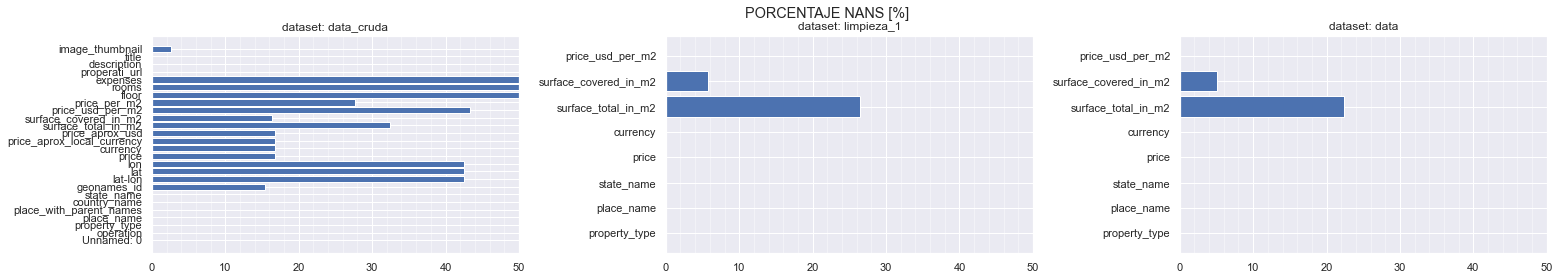

In [14]:
instancias = ['data_cruda', 'limpieza_1', 'data']
sns.set()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,4))
fig.suptitle('PORCENTAJE NANS [%]')
fig.subplots_adjust(wspace = 0.4)

for i in range(len(instancias)):
    df = pd.DataFrame(Dicto[instancias[i]][0])
    ax[i].barh(df.columna, df.pct_nan)
    ax[i].set(xlim = (0,50), title='dataset: '+instancias[i])
    ax[i].minorticks_on()
    ax[i].grid(which='minor', axis='x', lw=1, alpha=0.4)
    
"""
En la celda 5 está proporcionado un indicador de correlacion entre superficie cubierta y superficie total, por si se intenta rescatar algun dato de superficie total.
""";    

-------------------------------
                                                        DISTRIBUCIONES DE PROPERTY_TYPE EN FUNCION DE STATE_NAME
-----------------------  
                                                       

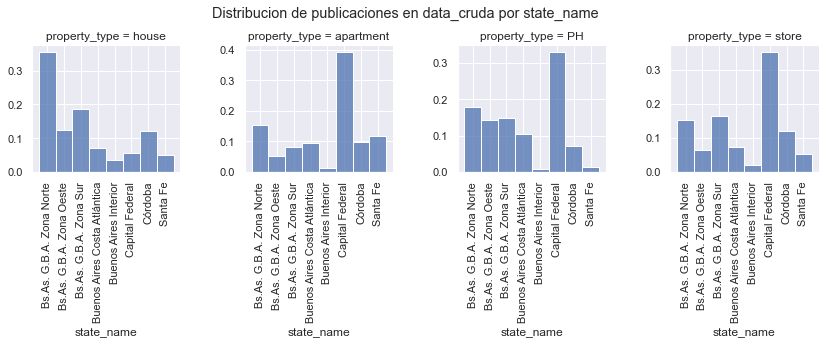

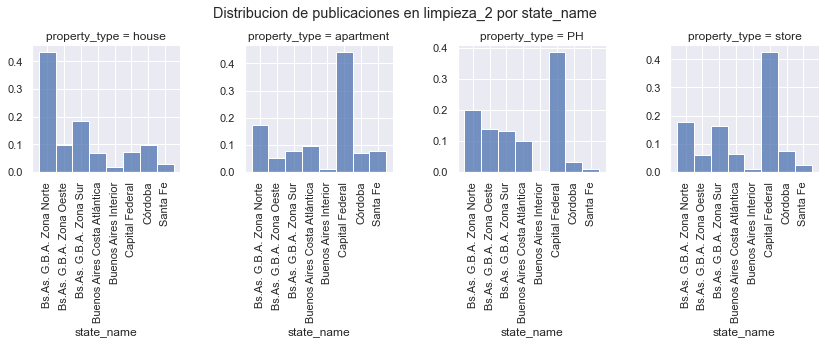

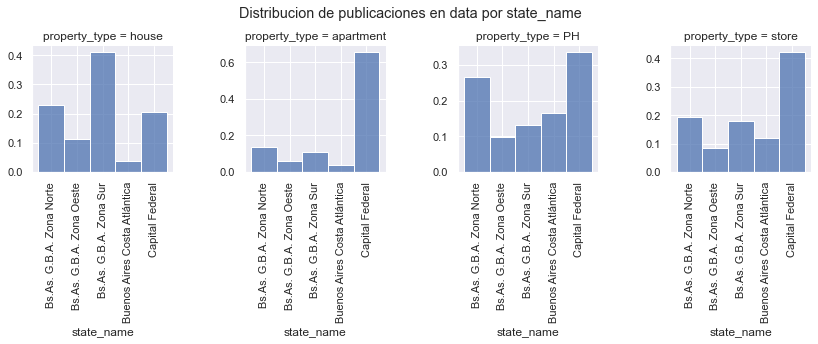

In [15]:
instancias = ['data_cruda','limpieza_2', 'data']

for i in range(len(instancias)):
    mask = (pd.DataFrame(Dicto[instancias[i]][1]).state_name == 'Capital Federal') | (pd.DataFrame(Dicto[instancias[i]][1]).state_name == 'Bs.As. G.B.A. Zona Norte') | (pd.DataFrame(Dicto[instancias[i]][1]).state_name == 'Bs.As. G.B.A. Zona Sur')|(pd.DataFrame(Dicto[instancias[i]][1]).state_name == 'Buenos Aires Costa Atlántica')| (pd.DataFrame(Dicto[instancias[i]][1]).state_name =='Córdoba') | (pd.DataFrame(Dicto[instancias[i]][1]).state_name =='Bs.As. G.B.A. Zona Oeste')|(pd.DataFrame(Dicto[instancias[i]][1]).state_name =='Santa Fe')|(pd.DataFrame(Dicto[instancias[i]][1]).state_name =='Buenos Aires Interior')
    g = sns.FacetGrid(pd.DataFrame(Dicto[instancias[i]][1]).loc[mask].sort_values(by='state_name'), col="property_type", margin_titles=True, sharex = False, sharey=False, col_order=['house', 'apartment', 'PH', 'store'])
    g.map(sns.histplot, 'state_name', stat='density')
    g.set_xticklabels(pd.DataFrame(Dicto[instancias[i]][1]).loc[mask].state_name.sort_values().unique(), rotation=90); #                                <-------------------------------------------- CONSULTA COMO CAMBIAR EL FIGSIZE?
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle('Distribucion de publicaciones en '+ instancias[i] + ' por state_name')

-------------
                                                        DISPERSIONES POR TIPO DE PROPIEDAD
--------------------------                                                        

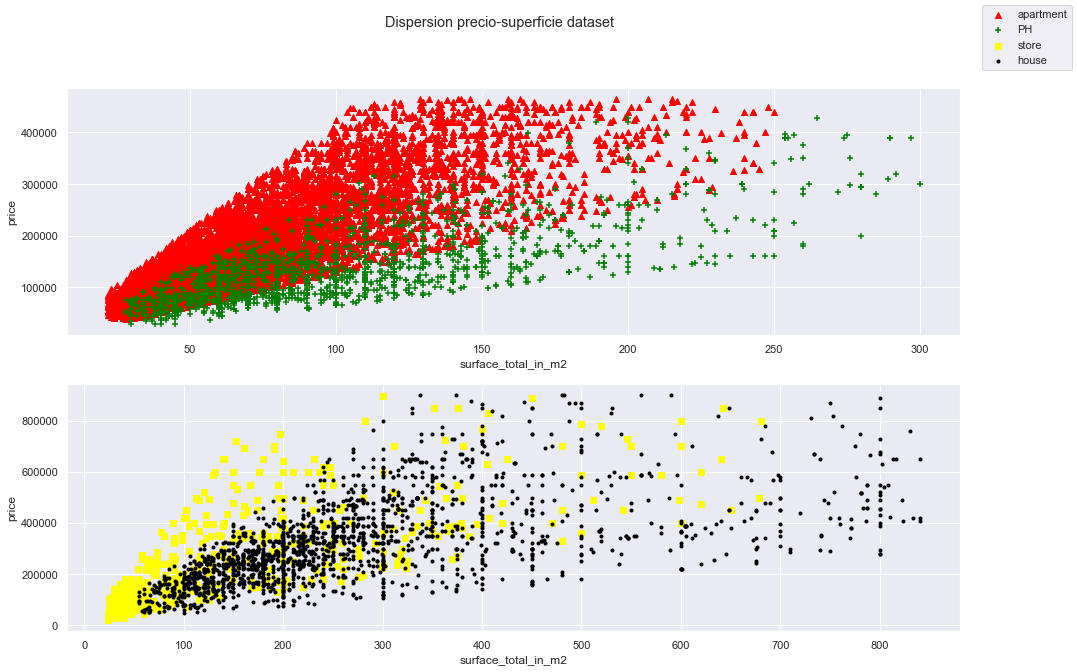

In [16]:
sns.set()
mask_1 = data.property_type == 'apartment'
mask_2 = data.property_type == 'PH'
mask_3 = data.property_type == 'house'
mask_4 = data.property_type == 'store'


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10))


ax[0].scatter(data.loc[mask_1].surface_total_in_m2, data.loc[mask_1].price, marker='^', color='red', label='apartment')
ax[0].scatter(data.loc[mask_2].surface_total_in_m2, data.loc[mask_2].price, marker='+', color='green', label='PH')
ax[1].scatter(data.loc[mask_4].surface_total_in_m2, data.loc[mask_4].price, marker='s', color='yellow', label='store')
ax[1].scatter(data.loc[mask_3].surface_total_in_m2, data.loc[mask_3].price, marker='.', color='black', label='house')


fig.legend()
ax[0].set(xlabel='surface_total_in_m2', ylabel='price')
ax[1].set(xlabel='surface_total_in_m2', ylabel='price')

fig.suptitle('Dispersion precio-superficie dataset');

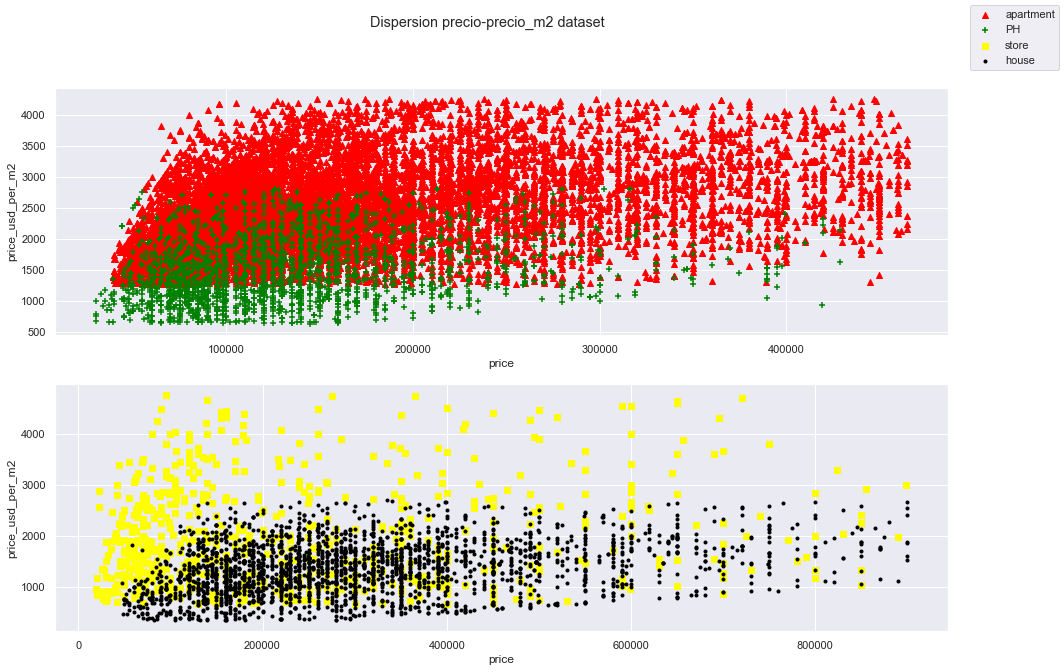

In [17]:
sns.set()
mask_1 = data.property_type == 'apartment'
mask_2 = data.property_type == 'PH'
mask_3 = data.property_type == 'house'
mask_4 = data.property_type == 'store'


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10))


ax[0].scatter(data.loc[mask_1].price, data.loc[mask_1].price_usd_per_m2, marker='^', color='red', label='apartment')
ax[0].scatter(data.loc[mask_2].price, data.loc[mask_2].price_usd_per_m2, marker='+', color='green', label='PH')
ax[1].scatter(data.loc[mask_4].price, data.loc[mask_4].price_usd_per_m2, marker='s', color='yellow', label='store')
ax[1].scatter(data.loc[mask_3].price, data.loc[mask_3].price_usd_per_m2, marker='.', color='black', label='house')


fig.legend()
ax[0].set(xlabel='price', ylabel='price_usd_per_m2')#, xlim= (0, 0.5e6), ylim = (0,4500))
ax[1].set(xlabel='price', ylabel='price_usd_per_m2')#, xlim = (0, 1e6), ylim=(0,4500))

fig.suptitle('Dispersion precio-precio_m2 dataset');

-----------
                                                                RANGO DE VALORES - UBICACION
-------------

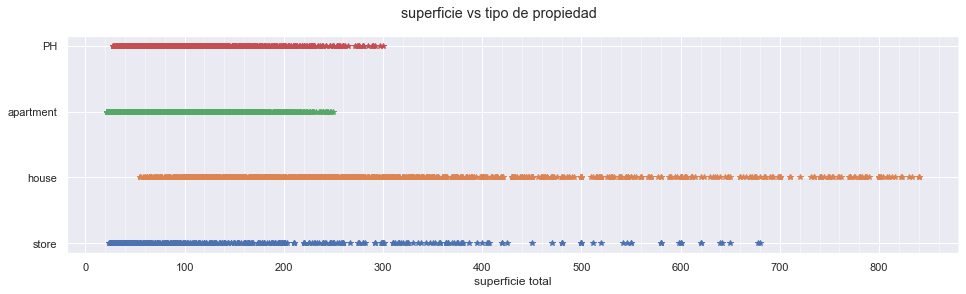

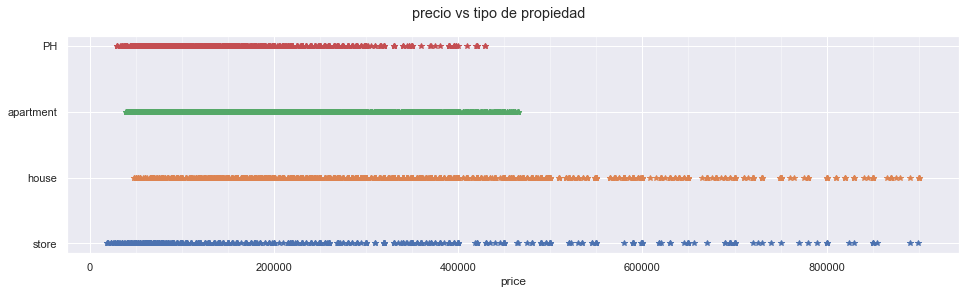

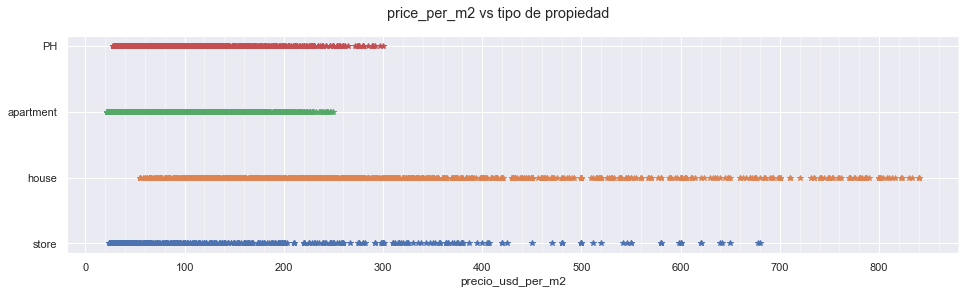

In [18]:
mark = '*'

fig = plt.figure(figsize = (16,4))
fig.suptitle('superficie vs tipo de propiedad')
ax = plt.axes()
set_check = set(list(data.property_type))
for propiedad in set_check:
    ax.plot(data[data.property_type==propiedad].surface_total_in_m2,data[data.property_type==propiedad].property_type , mark)
    ax.minorticks_on()
    ax.grid(which='minor', axis='x', lw=1, alpha=0.4)
ax.set(xlabel = 'superficie total');


fig = plt.figure(figsize = (16,4))
fig.suptitle('precio vs tipo de propiedad')
ax = plt.axes()
for propiedad in set_check:
    ax.plot(data[data.property_type==propiedad].price,data[data.property_type==propiedad].property_type , mark)
    ax.minorticks_on()
    ax.grid(which='minor', axis='x', lw=1, alpha=0.4)
ax.set(xlabel = 'price');


fig = plt.figure(figsize = (16,4))
fig.suptitle('price_per_m2 vs tipo de propiedad')
ax = plt.axes()
for propiedad in set_check:
    ax.plot(data[data.property_type==propiedad].surface_total_in_m2,data[data.property_type==propiedad].property_type , mark)
    ax.minorticks_on()
    ax.grid(which='minor', axis='x', lw=1, alpha=0.4)
ax.set(xlabel = 'precio_usd_per_m2');

-----------------
                                                                EXPLORACION POR STATE NAME

----------                                                                

* Limpieza de variabilidad de surface_total_in_m2

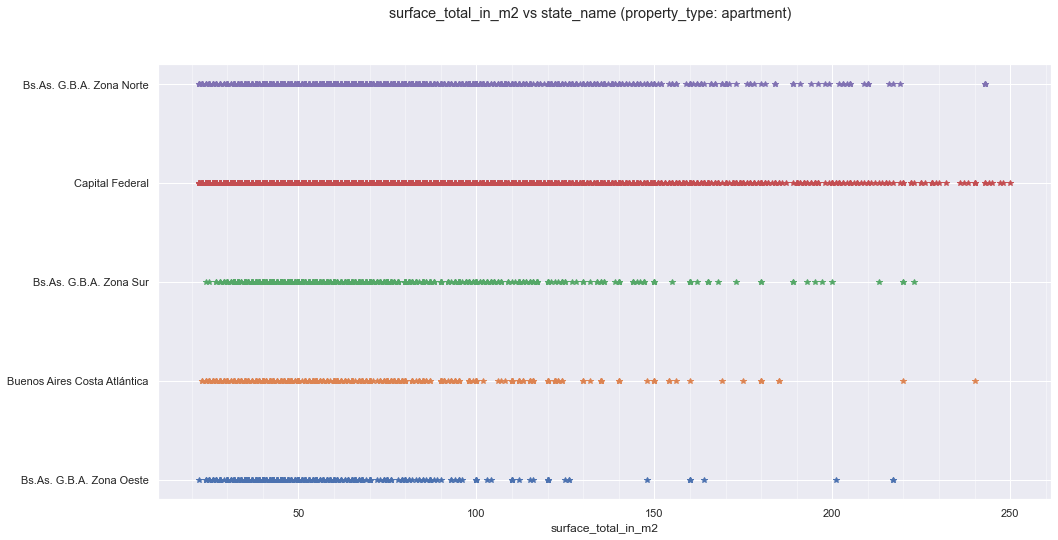

In [19]:
seccion = 'property_type'
tipo = 'apartment'
mask = data[seccion].isin([tipo])
x = 'surface_total_in_m2'
y = 'state_name'

fig = plt.figure(figsize = (16,8))
fig.suptitle(f'{x} vs {y} ({seccion}: {tipo})')
ax = plt.axes()

set_check = set(list(data[y]))
for elemento in set_check:
    ax.plot(data.loc[(data[seccion]==tipo)&(data[y]==elemento), x], data.loc[(data[seccion]==tipo)&(data[y]==elemento),y] , mark)
    ax.minorticks_on()
    ax.grid(which='minor', axis='x', lw=1, alpha=0.4)
ax.set(xlabel = x);

-------------------
### <u>Cierre<u>

In [20]:
pd.DataFrame(Dicto['data'][1]);

-----------------
                                                             LIMPIEZA OUTLIER POR SUPERFICIE Y POR STATE_NAME
                                                             
-------------------  

In [21]:
data = pd.DataFrame(Dicto['data'][1])

print ('EXCLUSION DE SUPERFICIE TOTAL')

exclusion = 'surface_total_in_m2'

serie_check = data.property_type

set_check = set(list(serie_check))
lista_drops = []

serie_check_2 = data.state_name
set_check_2 = set(list(serie_check_2))

for i,elemento in enumerate (set_check):
    print ('\n-------------- Iteracion elemento: {}--------------'.format(elemento))
    mascara_iter_1 = serie_check == elemento
    for state in set_check_2:
        print ('---- Iteracion state: {}----'.format(state))
        mascara_iter_2 = serie_check_2 == state
        
        if elemento == 'apartment':
            
            if state == 'Bs.As. G.B.A. Zona Sur':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 97.5])
            if state == 'Capital Federal':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 99])
            if state == 'Buenos Aires Costa Atlántica':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 95])
            if state == 'Bs.As. G.B.A. Zona Oeste':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 97.5])
            if state == 'Bs.As. G.B.A. Zona Norte':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 97.5])               

        elif elemento == 'PH':
            
            if state == 'Bs.As. G.B.A. Zona Sur':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 90])
            if state == 'Capital Federal':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 99])
            if state == 'Buenos Aires Costa Atlántica':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 96])
            if state == 'Bs.As. G.B.A. Zona Oeste':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 91])
            if state == 'Bs.As. G.B.A. Zona Norte':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 91.5])
        
        elif elemento == 'store':
            
            if state == 'Bs.As. G.B.A. Zona Sur':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 97.4])
            if state == 'Capital Federal':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 98.25])
            if state == 'Buenos Aires Costa Atlántica':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 94.8])
            if state == 'Bs.As. G.B.A. Zona Oeste':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 87.6])
            if state == 'Bs.As. G.B.A. Zona Norte':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 91.1])

        elif elemento == 'house':
            
            if state == 'Bs.As. G.B.A. Zona Sur':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 95])
            if state == 'Capital Federal':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 98])
            if state == 'Buenos Aires Costa Atlántica':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 71])
            if state == 'Bs.As. G.B.A. Zona Oeste':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 97.5])
            if state == 'Bs.As. G.B.A. Zona Norte':
                rango_outlier = rango_extremos(data.loc[mascara_iter_1 & mascara_iter_2], exclusion, [0.01, 96])                
                

        serie_outlier = data[exclusion].loc[mascara_iter_1 & mascara_iter_2] ##creo una serie para crear una mascara
        mask_data = data.loc[serie_outlier.index, exclusion].dropna() ###la mascara de la serie sin nans
        indice_outlier = mascara_outlier_index_list(data.loc[mask_data.index], exclusion, rango_outlier)
        print ('\t>>> items tirados: {}'.format(len(indice_outlier)))
        lista_drops.append(indice_outlier)


for lista_indices in lista_drops:
    data.drop(lista_indices, inplace=True)

EXCLUSION DE SUPERFICIE TOTAL

-------------- Iteracion elemento: store--------------
---- Iteracion state: Bs.As. G.B.A. Zona Oeste----
range_outlier: type: <class 'list'>, len: 2, value: [24.0, 401.5]
	>>> items tirados: 7
---- Iteracion state: Buenos Aires Costa Atlántica----
range_outlier: type: <class 'list'>, len: 2, value: [25.0, 349.0]
	>>> items tirados: 5
---- Iteracion state: Bs.As. G.B.A. Zona Sur----
range_outlier: type: <class 'list'>, len: 2, value: [24.0, 400.7]
	>>> items tirados: 3
---- Iteracion state: Capital Federal----
range_outlier: type: <class 'list'>, len: 2, value: [25.0, 510.8]
	>>> items tirados: 5
---- Iteracion state: Bs.As. G.B.A. Zona Norte----
range_outlier: type: <class 'list'>, len: 2, value: [25.0, 402.7]
	>>> items tirados: 10

-------------- Iteracion elemento: house--------------
---- Iteracion state: Bs.As. G.B.A. Zona Oeste----
range_outlier: type: <class 'list'>, len: 2, value: [60.0, 500.0]
	>>> items tirados: 6
---- Iteracion state: Buenos A

-----------------
                                                             LIMPIEZA VISUAL DE PRICE POR STATE_NAME
                                                             
-------------------

In [22]:
## por exploracion visual-manual se tiran las siguientes entradas
mask_1 = data.property_type=='apartment'
# el depto más caro de costa atlántica
data.drop(data[data.state_name == 'Buenos Aires Costa Atlántica'].loc[mask_1].price.idxmax(), inplace=True)
# los deptos más caros de de Zona Oeste
mask_2 = data.state_name == 'Bs.As. G.B.A. Zona Oeste'
rango_outlier = rango_extremos(data.loc[mask_1 & mask_2], 'price', [0.01, 99.1])
mask_outlier = data.loc[mask_1 & mask_2 , 'price'].dropna().index
indice_outlier = mascara_outlier_index_list(data.loc[mask_outlier], 'price', rango_outlier)
data.drop(indice_outlier, inplace=True) # that's the way, aja aja, I like it
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Oeste'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Oeste'].loc[mask_1].price.idxmax(), inplace=True)

# LIMPIANDO UN POCO LOS PH
mask_1 = data.property_type=='PH'
data.drop(data[data.state_name == 'Buenos Aires Costa Atlántica'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Oeste'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Oeste'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Sur'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Sur'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Sur'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Sur'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Sur'].loc[mask_1].price.idxmax(), inplace=True)

# ENBELLECIENDO EL PRECIO DEL LOS HOGARES PORTEÑOS ÑÑ 
mask_1 = data.property_type=='house'
for i in range(9):
    data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Oeste'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Buenos Aires Costa Atlántica'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Buenos Aires Costa Atlántica'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Buenos Aires Costa Atlántica'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Buenos Aires Costa Atlántica'].loc[mask_1].price.idxmax(), inplace=True)

# INTENTANDO DARLE FORMA A LA AMORFIDAD DE STORE
mask_1 = data.property_type=='store'
for i in range(7):
    data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Sur'].loc[mask_1].price.idxmax(), inplace=True)
    data.drop(data[data.state_name == 'Capital Federal'].loc[mask_1].price.idxmax(), inplace=True)
    data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Norte'].loc[mask_1].price.idxmax(), inplace=True)
for i in range(5):
    data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Oeste'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Sur'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Sur'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Bs.As. G.B.A. Zona Sur'].loc[mask_1].price.idxmax(), inplace=True)
data.drop(data[data.state_name == 'Buenos Aires Costa Atlántica'].loc[mask_1].price.idxmax(), inplace=True)

range_outlier: type: <class 'list'>, len: 2, value: [39162.3, 315655.0]


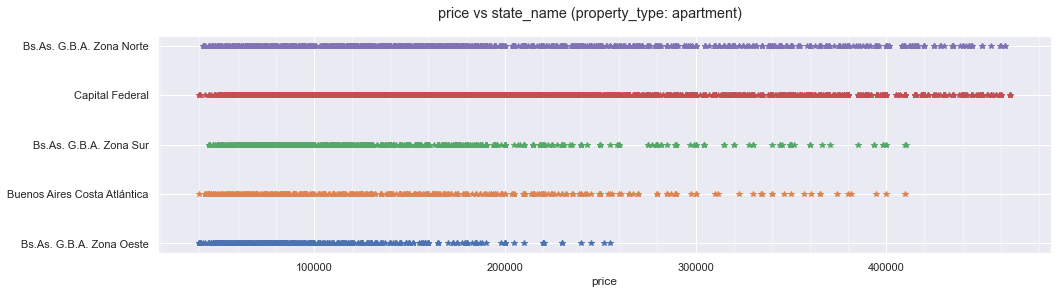

In [23]:
seccion = 'property_type'
tipo = 'apartment'
mask = data[seccion].isin([tipo])
x = 'price'
y = 'state_name'

fig = plt.figure(figsize = (16,4))
fig.suptitle(f'{x} vs {y} ({seccion}: {tipo})')
ax = plt.axes()

set_check = set(list(data[y]))
for elemento in set_check:
    ax.plot(data.loc[(data[seccion]==tipo)&(data[y]==elemento), x], data.loc[(data[seccion]==tipo)&(data[y]==elemento),y] , mark)
    ax.minorticks_on()
    ax.grid(which='minor', axis='x', lw=1, alpha=0.4)
ax.set(xlabel = x);

-----------------
                                                             CATEGORIZACION PLACE_NAME POR APARTMENT (VALOR "OTROS")
                                                             
-------------------  

(21434, 8)

apartment    15942
house         2583
PH            2212
store          697
Name: property_type, dtype: int64

Se categoriza aquellas place_name con cantidad menor a 83 publicaciones como "otros"


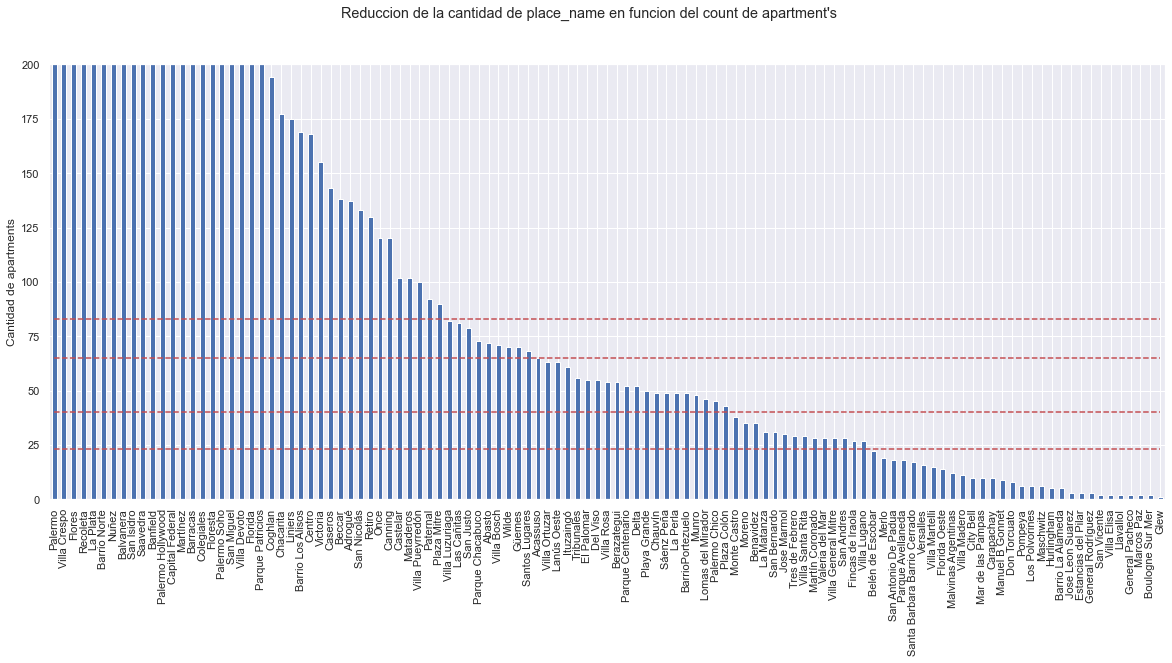

In [24]:
display (data.shape)
df = data_info(data, 'data')
display (data.property_type.value_counts())

df
fig = plt.figure(figsize=(20,8))
fig.suptitle('Reduccion de la cantidad de place_name en funcion del count de apartment\'s')
ax = plt.axes()
ax.set(ylim=(0,200), ylabel = 'Cantidad de apartments')


data[data.property_type=='apartment'].place_name.value_counts().plot.bar()

plt.plot([83]*len(data[data.property_type=='apartment'].place_name.value_counts()), "r--")
plt.plot([65]*len(data[data.property_type=='apartment'].place_name.value_counts()), "r--")
plt.plot([40]*len(data[data.property_type=='apartment'].place_name.value_counts()), "r--")
plt.plot([23]*len(data[data.property_type=='apartment'].place_name.value_counts()), "r--")

print ('Se categoriza aquellas place_name con cantidad menor a 83 publicaciones como "otros"')

In [25]:
df = explore_count(data,'place_name')
df = explore_count_by(data, 'place_name', 'property_type', df)
df = df.loc[:,['total', 'count_apartment']]
lista_place_name = list(df[df.count_apartment < 83].sort_values(by='count_apartment', ascending=False).index)

lista_place_name;

data.loc[data.place_name.isin(lista_place_name), 'place_name_2'] = 'otros'
data['place_name_2'].fillna(data['place_name'], inplace=True)

Dicto['data'] = data_info(data).to_dict(), data.to_dict()

data

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2
11223,house,Palermo Soho,Capital Federal,500000.0,USD,211.0,NaN,2369.668246,Palermo Soho
50491,house,Palermo Soho,Capital Federal,310000.0,USD,340.0,240.0,911.764706,Palermo Soho
55311,house,Palermo Soho,Capital Federal,500000.0,USD,211.0,NaN,2369.668246,Palermo Soho
65135,house,Palermo Soho,Capital Federal,490000.0,USD,220.0,150.0,2227.272727,Palermo Soho
119294,house,Palermo Soho,Capital Federal,680000.0,USD,270.0,200.0,2518.518519,Palermo Soho
...,...,...,...,...,...,...,...,...,...
14653,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,99000.0,USD,NaN,105.0,942.857143,Ciudadela
56361,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,85000.0,USD,87.0,87.0,977.011494,Ciudadela
56408,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,320000.0,USD,180.0,180.0,1777.777778,Ciudadela
36148,store,Merlo,Bs.As. G.B.A. Zona Oeste,270000.0,USD,375.0,333.0,720.000000,otros


-----------------
                                                             RECUPERO DE LAS COLUMNAS DESCRIPTIVAS
                                                             
------------------- 

* Del dataset original: creacion data_apartment_1
* De la busqueda RegEx del workshop_1: creacion data_apartment_2

In [26]:
data_aux = pd.DataFrame(Dicto['data_cruda'][1])
data_aux = data_aux[data_aux[['floor','rooms','expenses']].any(axis=1)].loc[:, ['floor','rooms','expenses']]
data_aux

,floor,rooms,expenses
13,NaN,1.0,NaN
14,NaN,1.0,NaN
16,NaN,4.0,NaN
17,NaN,3.0,NaN
19,NaN,3.0,NaN
...,...,...,...
121207,NaN,NaN,3000.0
121208,NaN,NaN,3000.0
121209,NaN,NaN,6300.0
121215,NaN,NaN,10000.0


In [27]:
data = pd.DataFrame(Dicto['data'][1])

indices = data.index.intersection(data_aux.index)
data_aux = data_aux.loc[indices]

data = data.join(data_aux)
data

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2,floor,rooms,expenses
11223,house,Palermo Soho,Capital Federal,500000.0,USD,211.0,NaN,2369.668246,Palermo Soho,NaN,NaN,NaN
50491,house,Palermo Soho,Capital Federal,310000.0,USD,340.0,240.0,911.764706,Palermo Soho,NaN,NaN,NaN
55311,house,Palermo Soho,Capital Federal,500000.0,USD,211.0,NaN,2369.668246,Palermo Soho,NaN,NaN,NaN
65135,house,Palermo Soho,Capital Federal,490000.0,USD,220.0,150.0,2227.272727,Palermo Soho,NaN,NaN,NaN
119294,house,Palermo Soho,Capital Federal,680000.0,USD,270.0,200.0,2518.518519,Palermo Soho,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
14653,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,99000.0,USD,NaN,105.0,942.857143,Ciudadela,NaN,NaN,NaN
56361,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,85000.0,USD,87.0,87.0,977.011494,Ciudadela,NaN,NaN,NaN
56408,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,320000.0,USD,180.0,180.0,1777.777778,Ciudadela,NaN,NaN,NaN
36148,store,Merlo,Bs.As. G.B.A. Zona Oeste,270000.0,USD,375.0,333.0,720.000000,otros,NaN,NaN,NaN


**<u>data_apartment_1:<u>**

In [28]:
data_apartment_1 = data[data[['floor', 'rooms', 'expenses']].any(axis=1)].loc[data.property_type=='apartment']
data_apartment_1
data_apartment_1.place_name_2.value_counts()[:10]

otros           1806
Palermo         1298
Recoleta         719
Villa Crespo     699
Flores           687
Barrio Norte     659
Balvanera        448
La Plata         417
Nuñez            371
San Isidro       320
Name: place_name_2, dtype: int64

In [29]:
try:
    data_geo = pd.read_csv('data_geo.csv')
    data_geo = data_geo.iloc[:, -18:]

    recuperados = [['complejo_1', 'complejo_2'], ['barrio_1', 'barrio_2', 'barrio_3'], ['en_sobre_1', 'en_sobre_2', 'en_sobre_3'], ['sobre_calle_1', 'sobre_calle_2', 'sobre_calle_3'], ['en_calle', 'entre'], ['en_bv', 'en_boulevar'], ['en_av', 'en_avenida']]
    lista_categorias = ['estrategico', 'exclusivo', 'estrategico', None, 'estrategico', None, 'exclusivo']
    lista_indices = []

    for i,patron in enumerate(recuperados):
        mask_data = data_geo.loc[:,patron].any(axis=1)
        indice_mask = data_geo.loc[mask_data, patron].index
        lista_indices.append(indice_mask)
    
    columnas = []
    data_check = data_geo.loc[data_geo.loc[:,recuperados[3]].any(axis=1), recuperados[3]]
    data_check.columns = ['1','2','3']
    data_check['1'].fillna(data_check['2'], inplace=True)
    data_check['1'].fillna(data_check['3'],inplace=True)

    for i in range(len(lista_categorias)):
        if i == 3:
            name = 'direccion'
            data.loc[data.index.intersection(lista_indices[i]), name] = data_check['1']
    
        else:
            name = 'regex'+ str(i+1)
            data.loc[data.index.intersection(lista_indices[i]), name] = lista_categorias[i]
            data.loc[data.index.intersection(lista_indices[i]), name] = lista_categorias[i]
        columnas.append(name)
    
    data[data['regex7'].notna()] # regex1 y 3 y 5 : estrategico # regex2 y 7: exclusivo # drop columna 6

    data.regex1.fillna(data.regex3, inplace=True)
    data.regex1.fillna(data.regex5, inplace=True)
    data.regex2.fillna(data.regex7, inplace=True)
    data.drop(['regex3', 'regex5', 'regex6', 'regex7'], axis=1, inplace=True)

    data[data[['regex1', 'regex2', 'direccion']].any(axis=1)].loc[:, 'property_type'].value_counts() # print para ver a que tipo y cuantas propiedades afecta  <--- a ver!
except:
    print ('falta el archivo data_geo.csv')

finally:
    data

**<u>data_apartment_2:<u>**

In [30]:
try:
    data_apartment_2 = data[data[['regex1', 'regex2', 'direccion']].any(axis=1)].loc[data.property_type == 'apartment'] # <- veo que exclusivo es más barato que estrategico

    data_apartment_2.place_name_2.value_counts()[:10]
    
except:
    pass

**<u>data_apartment_3:<u>**

In [31]:
try:
    data_apartment_2_1 = data_apartment_2.loc[data_apartment_2.index.intersection(data_apartment_1.index)]
    data_apartment_3 = pd.concat([data_apartment_1, data_apartment_2_1], join='outer')
    data_apartment_3.place_name_2.value_counts()[:10]
except:
    pass

-----------------
                                                             CATEGORIZACION DE LA SUPERFICIE
                                                             
-------------------

Crear una columna que categorice a la superficie por debajo y por ncima de la media para cada place_name

In [32]:
def explore_separated(df):
    filtro_1_1 = list(df.columns)[:2]
    filtro_2_1 = list(df.columns)[:3:2]
    filtro_3_1 = list(df.columns)[:4:3]
    filtro_4_1 = list(df.columns)[:5:4]

    filtro_1_2 = list(df.columns)[5:8]
    filtro_2_2 = list(df.columns)[8:11]
    filtro_3_2 = list(df.columns)[11:14]
    filtro_4_2 = list(df.columns)[14:17]

    filtro_1_3 = list(df.columns)[17:18]
    filtro_2_3 = list(df.columns)[18:19]
    filtro_3_3 = list(df.columns)[19:20]
    filtro_4_3 = list(df.columns)[20:21]

    filtro_1 = filtro_1_1 + filtro_1_2 + filtro_1_3
    filtro_2 = filtro_2_1 + filtro_2_2 + filtro_2_3
    filtro_3 = filtro_3_1 + filtro_3_2 + filtro_3_3
    filtro_4 = filtro_4_1 + filtro_4_2 + filtro_4_3

    df_1 = df.loc[:,filtro_1].to_dict()
    df_2 = df.loc[:,filtro_2].to_dict()
    df_3 = df.loc[:,filtro_3].to_dict()
    df_4 = df.loc[:,filtro_4].to_dict()
    
    Explore = {}
    
    for i in range(4):
        label = 'explore_'+str(i+1)
        if i == 0: Explore[label] = df_1
        elif i == 1: Explore[label] = df_2
        elif i == 2: Explore[label] = df_3
        elif i == 3: Explore[label] = df_4

    return Explore

In [33]:
indice = 'place_name'
columna_count = 'property_type'
columna_estadistico = 'surface_total_in_m2'

df= explore_count_by(data, indice, columna_count, explore_count(data, indice))
df = explore_statics_count(data, indice, columna_count, columna_estadistico, df)

dicc_explore = explore_separated(df)

df_1 = pd.DataFrame(dicc_explore['explore_1'])
df_2 = pd.DataFrame(dicc_explore['explore_2'])
df_3 = pd.DataFrame(dicc_explore['explore_3'])
df_4 = pd.DataFrame(dicc_explore['explore_4'])

lista = [df_1, df_2, df_3, df_4]

for frame in lista:
    if frame.columns[1] == 'count_apartment':
        df_apartment = frame.copy()

df_apartment.sort_values(by='apartment_mean_surface_total_in_m2', ascending = False) # print para ver el dataset statistic de apartments

apartment_mean = df_apartment['apartment_mean_surface_total_in_m2'].dropna()
apartment_mean;

In [34]:
lista_place_name = apartment_mean.index
lista_apartment_mean = apartment_mean.values

for i, elemento in enumerate(lista_place_name):
    mascara_iter_1 = data['property_type'] == 'apartment'
    #display(np.array((data.loc[mascara_iter_1 & (data.place_name == elemento), 'surface_total_in_m2']) >= lista_apartment_mean[i]).astype(int)) # columna dummy
    data.loc[mascara_iter_1 & (data.place_name == elemento), 'above_mean'] = np.array((data.loc[mascara_iter_1 & (data.place_name == elemento), 'surface_total_in_m2']) >= lista_apartment_mean[i]).astype(int)
    
data[data.property_type=='apartment']

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2,floor,rooms,expenses,regex1,regex2,direccion,above_mean
2,apartment,Mataderos,Capital Federal,72000.0,USD,55.0,55.0,1309.090909,Mataderos,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5189,apartment,Mataderos,Capital Federal,67000.0,USD,40.0,28.0,1675.000000,Mataderos,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6450,apartment,Mataderos,Capital Federal,90000.0,USD,52.0,48.0,1730.769231,Mataderos,NaN,NaN,200.0,NaN,NaN,NaN,0.0
7725,apartment,Mataderos,Capital Federal,88000.0,USD,50.0,38.0,1760.000000,Mataderos,NaN,2.0,500.0,NaN,NaN,NaN,0.0
8339,apartment,Mataderos,Capital Federal,93600.0,USD,51.0,46.0,1835.294118,Mataderos,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29685,apartment,Villa Madero,Bs.As. G.B.A. Zona Oeste,83000.0,USD,51.0,51.0,1627.450980,otros,NaN,3.0,NaN,NaN,NaN,NaN,1.0
31463,apartment,Villa Madero,Bs.As. G.B.A. Zona Oeste,75000.0,USD,43.0,40.0,1744.186047,otros,4.0,2.0,1000.0,NaN,NaN,NaN,0.0
36947,apartment,Villa Madero,Bs.As. G.B.A. Zona Oeste,75000.0,USD,33.0,31.0,2272.727273,otros,NaN,1.0,NaN,NaN,NaN,NaN,0.0
61264,apartment,Villa Madero,Bs.As. G.B.A. Zona Oeste,94000.0,USD,46.0,43.0,2043.478261,otros,1.0,2.0,850.0,estrategico,NaN,NaN,0.0


In [35]:
data[data.property_type=='apartment'].above_mean.isna().sum()

0

-----------------
                                                             DESCARGA DE LA DATA
                                                             
-------------------                                                             

In [36]:
data.to_csv('data_workshop_2.csv')

if descargar_data_apartment_:
    
    data_apartment_1.to_csv('data_apartment_1.csv')
    try:
        data_apartment_2.to_csv('data_apartment_2.csv')
        data_apartment_3.to_csv('data_apartment_3.csv') # este tiene un index intersection
    except:
        print ('raise error: file missing - named: "data_geo"')
    df_apartment.to_csv('data_apartment_4_statistic.csv') # la fraccion de explore_static_count
    data[data.property_type=='apartment'].to_csv('data_apartment_5_final.csv')
data

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2,floor,rooms,expenses,regex1,regex2,direccion,above_mean
11223,house,Palermo Soho,Capital Federal,500000.0,USD,211.0,NaN,2369.668246,Palermo Soho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50491,house,Palermo Soho,Capital Federal,310000.0,USD,340.0,240.0,911.764706,Palermo Soho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55311,house,Palermo Soho,Capital Federal,500000.0,USD,211.0,NaN,2369.668246,Palermo Soho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65135,house,Palermo Soho,Capital Federal,490000.0,USD,220.0,150.0,2227.272727,Palermo Soho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119294,house,Palermo Soho,Capital Federal,680000.0,USD,270.0,200.0,2518.518519,Palermo Soho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14653,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,99000.0,USD,NaN,105.0,942.857143,Ciudadela,NaN,NaN,NaN,estrategico,NaN,NaN,NaN
56361,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,85000.0,USD,87.0,87.0,977.011494,Ciudadela,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56408,store,Ciudadela,Bs.As. G.B.A. Zona Oeste,320000.0,USD,180.0,180.0,1777.777778,Ciudadela,NaN,NaN,NaN,estrategico,NaN,NaN,NaN
36148,store,Merlo,Bs.As. G.B.A. Zona Oeste,270000.0,USD,375.0,333.0,720.000000,otros,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#help(plt.axes);
#help(plt.figure);
#help(axes.set_xticks);
#help(sns.FacetGrid.map_dataframe);
#help(sns.FacetGrid.map);
#help(plt.hist)
#help(sns.kdeplot)
#help(sns.pairplot)
#help(sns.set)

In [38]:
# FINAL NOTEBOOK
data[data.property_type == 'apartment']

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2,floor,rooms,expenses,regex1,regex2,direccion,above_mean
2,apartment,Mataderos,Capital Federal,72000.0,USD,55.0,55.0,1309.090909,Mataderos,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5189,apartment,Mataderos,Capital Federal,67000.0,USD,40.0,28.0,1675.000000,Mataderos,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6450,apartment,Mataderos,Capital Federal,90000.0,USD,52.0,48.0,1730.769231,Mataderos,NaN,NaN,200.0,NaN,NaN,NaN,0.0
7725,apartment,Mataderos,Capital Federal,88000.0,USD,50.0,38.0,1760.000000,Mataderos,NaN,2.0,500.0,NaN,NaN,NaN,0.0
8339,apartment,Mataderos,Capital Federal,93600.0,USD,51.0,46.0,1835.294118,Mataderos,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29685,apartment,Villa Madero,Bs.As. G.B.A. Zona Oeste,83000.0,USD,51.0,51.0,1627.450980,otros,NaN,3.0,NaN,NaN,NaN,NaN,1.0
31463,apartment,Villa Madero,Bs.As. G.B.A. Zona Oeste,75000.0,USD,43.0,40.0,1744.186047,otros,4.0,2.0,1000.0,NaN,NaN,NaN,0.0
36947,apartment,Villa Madero,Bs.As. G.B.A. Zona Oeste,75000.0,USD,33.0,31.0,2272.727273,otros,NaN,1.0,NaN,NaN,NaN,NaN,0.0
61264,apartment,Villa Madero,Bs.As. G.B.A. Zona Oeste,94000.0,USD,46.0,43.0,2043.478261,otros,1.0,2.0,850.0,estrategico,NaN,NaN,0.0
